<h1> <center> GEOG 172: INTERMEDIATE GEOGRAPHICAL ANALYSIS </h1>
    <h2> <center> Evgeny Noi </h2>
        <h3> <center> Lecture 18: Multi-scale Geographically Weighted Regression </h3>

# Regression Modeling for Spatial Relations

1. Spatial heterogeneity 
    1. Fixed-effect model
    2. Spatial regimes 
2. Spatial Dependence 
    1. SLX (spatial feature engineering) 
    2. Spatial error model
    3. Spatial lag model 
3. Local Modeling Frameworks (GWR and MGWR)

<img src="https://gistbok.ucgis.org/sites/default/files/AM34_Fig1.png">

# (M)GWR 

* estimate location-dependent relationship between dependent and independent variables 
* place-based analytic technique
* GWR models borrow data from neighboring observations and weight these data according to a smooth decay function based on either a physical distance or the number of nearest neighbors (higher weight for nearby locations) 

# (M)GWR 

* Small bandwidths denote more local processes; large bandwidths indicate regional or global processes.  
* As long as an **optimal bandwidth** is determined in the calibration of the GWR model and some continuous smooth function of distance is used, the **specific kernel function chosen is not critical**.

<img src="https://gistbok.ucgis.org/sites/default/files/AM34_Fig2.png" width="500px">

<img src="https://gistbok.ucgis.org/sites/default/files/AM34_Fig3.png">

# Selecting Optimal Bandwidth 

* Trade-off between bias and variance. 
* As bw increases, the bias increases, because we are borrowing from locations that could have been generated by increasingly different processes 
* As bw decreases, the local parameter estimation uncertainty rises (fewer data points)  
* Statistical optimization: trade-off between model fit and model complexity (e.g. AIC) 

# GWR Model Specification 

$$
Y_i = \beta_0(u_i, v_i) + \sum_{j}\beta_j(u_i, v_i)X_{ji} + \epsilon_i
$$

where $j$ is the number of dependent variables and $\beta$ vary across space (**surface estimation**)

* overlapping sets of points are used, classical t-tests are not appropriate, thus $\alpha$ needs to be corrected and MC appliedd

$$
\alpha = \frac{\xi}{\frac{ENP}{p}}
$$

# MGWR Model Specification 

$$
Y_i = \beta_0(u_i, v_i) + \sum_{j}\beta_{bwj}(u_i, v_i)X_{ji} + \epsilon_i
$$

where $\beta_{bwj}$ indicates the bandwidth used for calibration of the $j$th relationship. 

<img src="https://gistbok.ucgis.org/sites/default/files/AM34_Fig4.png">

# (M)GWR Limitations

* More computationally intensive (if you have >500 observations might take too long on desktop computers) 
* Limited interpretation

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
import seaborn as sns
import pingouin as pg
import statsmodels
import statsmodels.formula.api as smf
from pysal.model import spreg
from libpysal.weights import Queen, Rook, KNN
from esda.moran import Moran
from pysal.explore import esda

C:\Users\barguzin\anaconda3\envs\geo_env\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
db = gpd.read_file("regression_db.geojson")
print(db.shape) 
db.head()

(6110, 20)


,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


In [3]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

Text(0.5, 1.0, 'AirBnb listing price in San Diego \n log(price)')

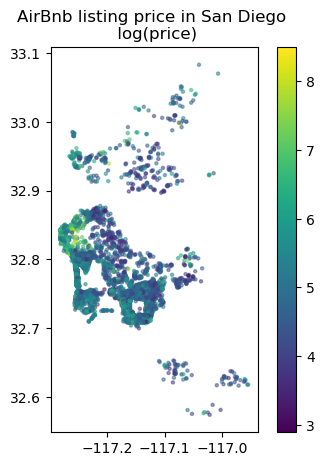

In [4]:
f,ax = plt.subplots(figsize=(5,5))
db.plot(column='log_price', ax=ax, legend=True, markersize=5, alpha=.5);
ax.set_title('AirBnb listing price in San Diego \n log(price)')

In [5]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

In [6]:
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

In [7]:
db.head()

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)


In [8]:
#Prepare Georgia dataset inputs
g_y = db['log_price'].values.reshape((-1,1))
g_X = db[variable_names].values

# reproject to get meters 
db = db.to_crs('EPSG:32611')

u = db.geometry.centroid.x
v = db.geometry.centroid.y
g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

# this rescales variables
g_y = g_y.reshape((-1,1))
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [9]:
#This might be needed to turn off the OpenMP multi-threading
# %env OMP_NUM_THREADS = 1

import multiprocessing as mp
# here is how to use parallalization (works better on local machine) 
n_proc = 4 #two processors
pool = mp.Pool(n_proc) 

In [10]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW

#Calibrate GWR model
gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit() #bw=384

384.0


In [11]:
gwr_results.localR2[0:10]

array([[0.64594203],
       [0.69396307],
       [0.59707561],
       [0.76902883],
       [0.68488587],
       [0.57839382],
       [0.65114373],
       [0.84073123],
       [0.7878669 ],
       [0.75561498]])

In [12]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                6110
Number of covariates:                                                    11

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2026.415
Log-likelihood:                                                   -5298.038
AIC:                                                              10618.075
AICc:                                                             10620.127
BIC:                                                             -51142.728
R2:                                                                   0.668
Adj. R2:                                                              0.668

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [13]:
# # THIS CODE TAKES TOO LONG TO RUN ON MY LAPTOP 
# #Calibrate MGWR model
# mgwr_selector = Sel_BW(g_coords, g_y, g_X, multi=True)
# mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
# print(mgwr_bw)
# mgwr_results = MGWR(g_coords, g_y, g_X, mgwr_selector).fit()

In [14]:
pool.close() # Close the pool when you finish
pool.join()

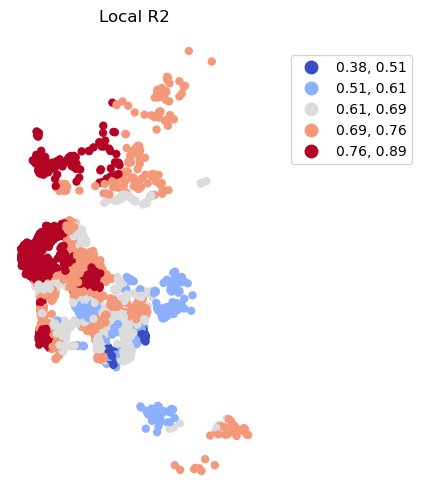

In [15]:
# Add R2 to GeoDataframe 
db['gwr_R2'] = gwr_results.localR2

fig, ax = plt.subplots(figsize=(6, 6))
db.plot(column='gwr_R2', cmap = 'coolwarm', linewidth=0.01, scheme = 'FisherJenks', k=5, legend=True, legend_kwds={'bbox_to_anchor':(1.10, 0.96)},  ax=ax)
ax.set_title('Local R2', fontsize=12)
ax.axis("off")
#plt.savefig('myMap.png',dpi=150, bbox_inches='tight')
plt.show()

In [16]:
#Add GWR parameters to GeoDataframe
db['gwr_intercept'] = gwr_results.params[:,0]
db['gwr_accom'] = gwr_results.params[:,1]
db['gwr_bathroom'] = gwr_results.params[:,2]
db['gwr_beddroom'] = gwr_results.params[:,3]

#Obtain t-vals filtered based on multiple testing correction
gwr_filtered_t = gwr_results.filter_tvals()

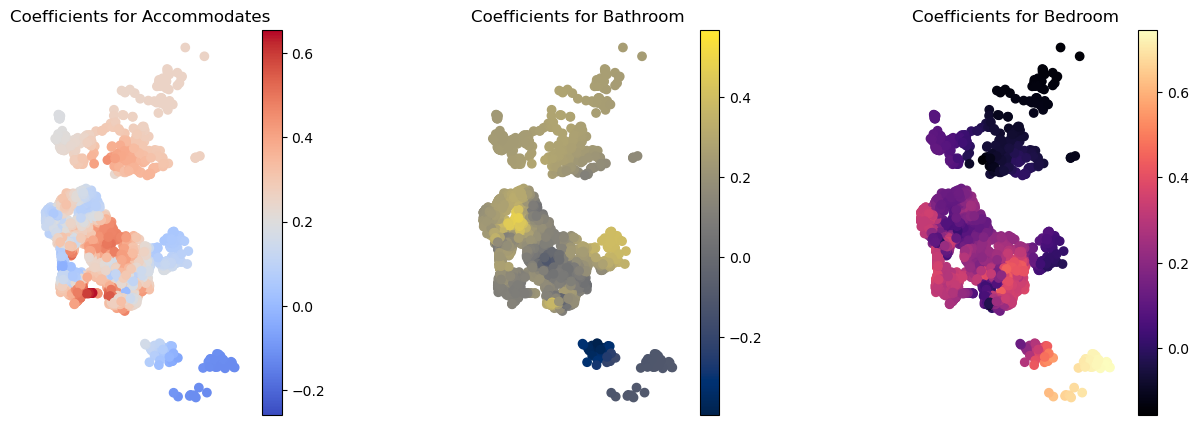

In [24]:
f, ax = plt.subplots(1,3, figsize=(16,5))

db.plot('gwr_accom',ax=ax[0], cmap='coolwarm', legend=True);
db.plot('gwr_bathroom',ax=ax[1], cmap='cividis', legend=True);
db.plot('gwr_beddroom',ax=ax[2], cmap='magma', legend=True);

ax[0].set_title('Coefficients for Accommodates');
ax[1].set_title('Coefficients for Bathroom');
ax[2].set_title('Coefficients for Bedroom');
ax[0].axis("off");ax[1].axis("off");ax[2].axis("off");

# How do we interpret these maps? 

# Questions? 

## Thank you for taking this class! 

### It was different from previous years, hopefully it has gotten you started on coding and programmatic spatial analysis! 